Import Package

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

Load Dataset

In [42]:
video_path = '../datasets/Test'
output_path = '../datasets/Train'
frame_interval = 10

In [43]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

for class_name in os.listdir(video_path):  # Looping setiap kategori (Abuse, Fighting, dll.)
    class_path = os.path.join(video_path, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip jika bukan folder

    output_class_path = os.path.join(output_path, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    for video_file in os.listdir(class_path):  # Looping setiap video dalam kategori
        video_file_path = os.path.join(class_path, video_file)
        
        # Pastikan itu file video
        if not video_file.endswith('.mp4'):
            continue

        cap = cv2.VideoCapture(video_file_path)
        frame_count = 0
        saved_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  # Stop jika tidak ada frame lagi

            if frame_count % frame_interval == 0:  # Simpan setiap `frame_interval` frame
                img_name = f"{video_file}_{saved_count}.jpg"
                img_path = os.path.join(output_class_path, img_name)
                cv2.imwrite(img_path, frame)
                saved_count += 1

            frame_count += 1

        cap.release()
        print(f"Processed {video_file}: {saved_count} images saved.")

print("✅ Semua video berhasil dikonversi ke gambar!")

Processed Abuse001_x264_0.mp4: 6 images saved.
Processed Abuse001_x264_1.mp4: 6 images saved.
Processed Abuse001_x264_10.mp4: 6 images saved.
Processed Abuse001_x264_11.mp4: 6 images saved.
Processed Abuse001_x264_12.mp4: 6 images saved.
Processed Abuse001_x264_13.mp4: 6 images saved.
Processed Abuse001_x264_14.mp4: 6 images saved.
Processed Abuse001_x264_15.mp4: 6 images saved.
Processed Abuse001_x264_16.mp4: 6 images saved.
Processed Abuse001_x264_17.mp4: 6 images saved.
Processed Abuse001_x264_18.mp4: 6 images saved.
Processed Abuse001_x264_19.mp4: 6 images saved.
Processed Abuse001_x264_2.mp4: 6 images saved.
Processed Abuse001_x264_20.mp4: 6 images saved.
Processed Abuse001_x264_21.mp4: 6 images saved.
Processed Abuse001_x264_22.mp4: 6 images saved.
Processed Abuse001_x264_23.mp4: 6 images saved.
Processed Abuse001_x264_24.mp4: 6 images saved.
Processed Abuse001_x264_25.mp4: 6 images saved.
Processed Abuse001_x264_26.mp4: 6 images saved.
Processed Abuse001_x264_27.mp4: 6 images sa

Data Augmentasi

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    output_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

val_data = datagen.flow_from_directory(
    output_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

class_labels = train_data.class_indices
print(class_labels)

Found 83866 images belonging to 13 classes.
Found 20960 images belonging to 13 classes.


Visualisasi beberapa contoh gambar dari dataset

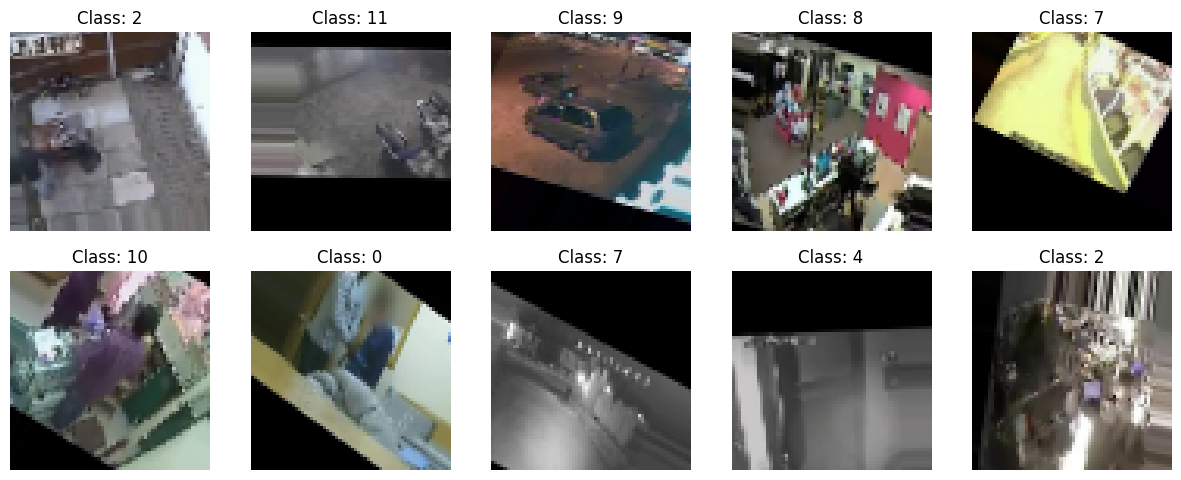

In [45]:
images, labels = next(train_data)

num_images = 10
plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i].argmax()}")
    plt.axis("off")

plt.show()

Image shape

In [46]:
print("Images Shape:",train_data.image_shape)

Images Shape: (64, 64, 3)


Extract Feature

In [ ]:
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model CNN untuk deteksi anomali multiclass

In [ ]:
model = tf.keras.models.Sequential([
    base_model,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(20, activation='softmax')
])


model.summary()

Training Model

In [ ]:
callbacks = EarlyStopping(
    patience=10,
    monitor='val_accuracy',
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

Fine tunning

In [ ]:
history = model.fit(
    train_data,
    epochs=10,
    callbacks=[callbacks, lr_scheduler],
    validation_data=val_data
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5242/5242 ━━━━━━━━━━━━━━━━━━━━ 1646s 311ms/step - accuracy: 0.4186 - loss: 1.9190 - val_accuracy: 0.2561 - val_loss: 2.5688 - learning_rate: 0.0010
Epoch 2/10
5242/5242 ━━━━━━━━━━━━━━━━━━━━ 977s 186ms/step - accuracy: 0.6160 - loss: 1.3188 - val_accuracy: 0.2391 - val_loss: 2.8099 - learning_rate: 0.0010
Epoch 3/10
5242/5242 ━━━━━━━━━━━━━━━━━━━━ 920s 176ms/step - accuracy: 0.6664 - loss: 1.1631 - val_accuracy: 0.2658 - val_loss: 2.7758 - learning_rate: 0.0010
Epoch 4/10
5242/5242 ━━━━━━━━━━━━━━━━━━━━ 928s 177ms/step - accuracy: 0.6975 - loss: 1.0655 - val_accuracy: 0.2691 - val_loss: 2.7077 - learning_rate: 0.0010
Epoch 5/10
5242/5242 ━━━━━━━━━━━━━━━━━━━━ 1071s 204ms/step - accuracy: 0.7223 - loss: 0.9943 - val_accuracy: 0.2850 - val_loss: 2.7226 - learning_rate: 0.0010
Epoch 6/10
5242/5242 ━━━━━━━━━━━━━━━━━━━━ 980s 187ms/step - accuracy: 0.7308 - loss: 0.9576 - val_accuracy: 0.2749 - val_loss: 2.7205 - learning_rate: 0.0010
Epoch 7/10
5242/5242 ━━━━━━━━━━━━━━━━━━━━ 952s 182

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

Evaluasi setelah fine tunning

In [51]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Loss (Fine-Tuning): {val_loss:.4f}")
print(f"Validation Accuracy (Fine-Tuning): {val_acc:.4f}")

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 212s 162ms/step - accuracy: 0.2917 - loss: 2.6384
Validation Loss (Fine-Tuning): 2.7014
Validation Accuracy (Fine-Tuning): 0.2964


Visualisasi hasil training dan akurasi validasi

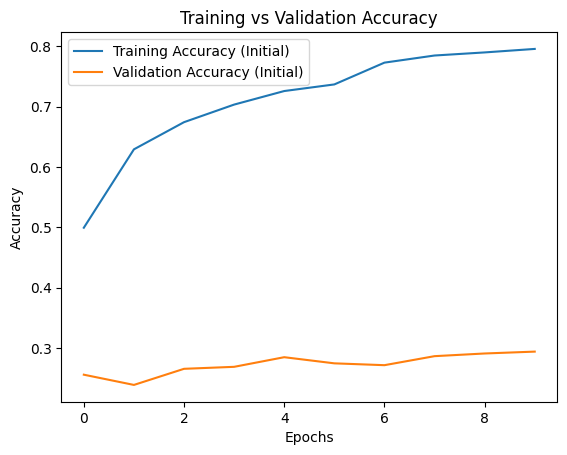

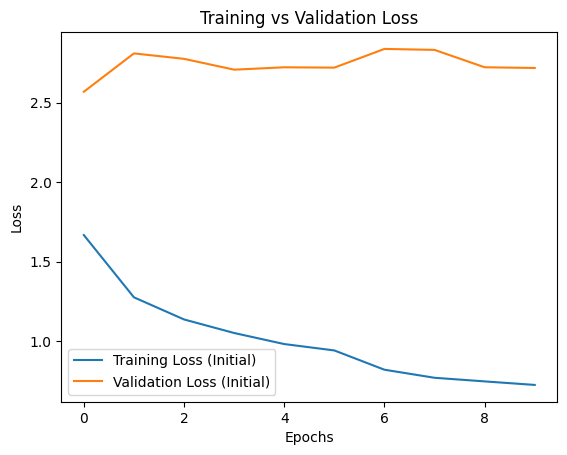

In [52]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Initial)')

plt.legend()
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss (Initial)')
plt.plot(history.history['val_loss'], label='Validation Loss (Initial)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Simpan model ke dalam file .h5

In [ ]:
model.save("../model/anomaly_detection_model.h5")